In [1]:
import sys
import pandas as pd
import configparser
import numpy as np
import matplotlib.pyplot as plt
#from datetime import datetime
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from data_helper import *

config = configparser.ConfigParser()
config.read('config/mypredictorconfig.ini')

eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

Using TensorFlow backend.


In [2]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df.head()

Grabbing WebIDs ...
WebID collection complete!
11:25:14: Sending API request... Chunk 1 of 1
11:25:14: Response recieved for 2 tags! (0.06)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-17 00:00:00,2620.899984,66.328080
2019-07-17 01:00:00,2614.991353,64.489932
2019-07-17 02:00:00,2623.946960,63.002730
2019-07-17 03:00:00,2627.607707,62.071544
2019-07-17 04:00:00,2679.489187,61.753234


In [3]:
df.tail()

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-29 06:00:00,2742.159536,64.044614
2019-07-29 07:00:00,2801.391673,67.477447
2019-07-29 08:00:00,2889.262685,71.153942
2019-07-29 09:00:00,3033.907623,74.436107
2019-07-29 10:00:00,3159.200582,78.079928


In [4]:
df1 = pc.get_stream_by_point('Future_TMY', end = '+2d', interval = interval, calculation = calculation)#
#df.rename(columns={'Future_TMY':'aiTIT4045'}, inplace=True)
#df.plot(figsize = (20,10))
df1.head()

Grabbing WebIDs ...
WebID collection complete!
11:25:14: Sending API request... Chunk 1 of 1
11:25:14: Response recieved for 1 tags! (0.04)


,Future_TMY
Timestamp,
2019-07-28 00:00:00,65.800003
2019-07-28 01:00:00,63.799999
2019-07-28 02:00:00,62.000000
2019-07-28 03:00:00,60.700001
2019-07-28 04:00:00,59.599998


In [5]:
new_df = pd.concat([df,df1], axis = 1, sort = False)
new_df.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045,Future_TMY
Timestamp,,,
2019-07-17 00:00:00,2620.899984,66.328080,NaN
2019-07-17 01:00:00,2614.991353,64.489932,NaN
2019-07-17 02:00:00,2623.946960,63.002730,NaN
2019-07-17 03:00:00,2627.607707,62.071544,NaN
2019-07-17 04:00:00,2679.489187,61.753234,NaN


In [6]:
new_df['aiTIT4045'].fillna(new_df.Future_TMY, inplace = True)
new_df.drop('Future_TMY', axis = 1, inplace = True)
print(new_df.shape)
print(f"How Many NaNs in Point: {new_df[point_name].isna().count()}")
new_df.tail()

(347, 2)
How Many NaNs in Point: 347


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-31 06:00:00,NaN,62.700001
2019-07-31 07:00:00,NaN,67.000000
2019-07-31 08:00:00,NaN,72.300003
2019-07-31 09:00:00,NaN,78.000000
2019-07-31 10:00:00,NaN,83.699997


In [43]:
new_df.loc[new_df[point_name].isna()].shape

(47, 2)

In [21]:
new_df.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-17 00:00:00,2620.899984,66.328080
2019-07-17 01:00:00,2614.991353,64.489932
2019-07-17 02:00:00,2623.946960,63.002730
2019-07-17 03:00:00,2627.607707,62.071544
2019-07-17 04:00:00,2679.489187,61.753234


In [22]:
end = new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())
end

299

In [26]:
#tail = new_df.iloc[end-10:]#.tail(10)
tail = new_df.iloc[:end+1].tail(15)
tail

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2019-07-28 21:00:00,2724.865194,85.500434
2019-07-28 22:00:00,2683.317810,79.042434
2019-07-28 23:00:00,2651.434316,75.311995
2019-07-29 00:00:00,2690.338969,73.564556
2019-07-29 01:00:00,2654.090963,71.459763
2019-07-29 02:00:00,2636.678009,67.399727
2019-07-29 03:00:00,2601.586873,65.416604
2019-07-29 04:00:00,2598.955058,65.029013
2019-07-29 05:00:00,2608.503642,64.060715


In [27]:
ddf = create_standard_multivariable_df(tail, shift = 3, dropna = False)
ddf

Generated: 49 columns


,GBSF_Electricity_Demand_kBtu,OAT,CDD,HDD,CDD2,HDD2,WEEKEND,SHIFT_3,Rolling24_mean,Rolling24_max,...,TOD_20,TOD_21,TOD_22,TOD_23,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-07-28 21:00:00,2724.865194,85.500434,20.500434,0.000000,420.267805,0.000000,1,NaN,2724.865194,2724.865194,...,0,1,0,0,0,0,0,0,0,1
2019-07-28 22:00:00,2683.317810,79.042434,14.042434,0.000000,197.189962,0.000000,1,NaN,2704.091502,2724.865194,...,0,0,1,0,0,0,0,0,0,1
2019-07-28 23:00:00,2651.434316,75.311995,10.311995,0.000000,106.337245,0.000000,1,NaN,2686.539107,2724.865194,...,0,0,0,1,0,0,0,0,0,1
2019-07-29 00:00:00,2690.338969,73.564556,8.564556,0.000000,73.351611,0.000000,0,2724.865194,2687.489072,2724.865194,...,0,0,0,0,0,0,0,0,0,0
2019-07-29 01:00:00,2654.090963,71.459763,6.459763,0.000000,41.728536,0.000000,0,2683.317810,2680.809450,2724.865194,...,0,0,0,0,0,0,0,0,0,0
2019-07-29 02:00:00,2636.678009,67.399727,2.399727,0.000000,5.758690,0.000000,0,2651.434316,2673.454210,2724.865194,...,0,0,0,0,0,0,0,0,0,0
2019-07-29 03:00:00,2601.586873,65.416604,0.416604,0.000000,0.173559,0.000000,0,2690.338969,2663.187448,2724.865194,...,0,0,0,0,0,0,0,0,0,0
2019-07-29 04:00:00,2598.955058,65.029013,0.029013,0.000000,0.000842,0.000000,0,2654.090963,2655.158399,2724.865194,...,0,0,0,0,0,0,0,0,0,0
2019-07-29 05:00:00,2608.503642,64.060715,0.000000,0.939285,0.000000,0.882256,0,2636.678009,2649.974537,2724.865194,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ddf.shape

In [28]:
ddf1 = ddf.iloc[:-1,:].dropna()
ddf1.shape

(11, 51)

In [29]:
ddf1 = ddf1.append(ddf.iloc[-1], verify_integrity = True)
ddf1.shape

(12, 51)

In [30]:
df = ddf1.copy()


In [31]:
# Model reconstruction from JSON file
weight_name = config['infiles']['weight_name']
arch_name = config['infiles']['arch_name']

with open(arch_name, 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights(weight_name)



W0729 11:43:02.834504 4547761600 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 11:43:02.849889 4547761600 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 11:43:02.852440 4547761600 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 11:43:03.147968 4547761600 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name 

In [32]:
look_back = config['MODEL']['look_back']
anomaly_threshold = int(config['MODEL']['anomaly_threshold'])

In [ ]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)

In [ ]:
df = create_standard_multivariable_df(df)

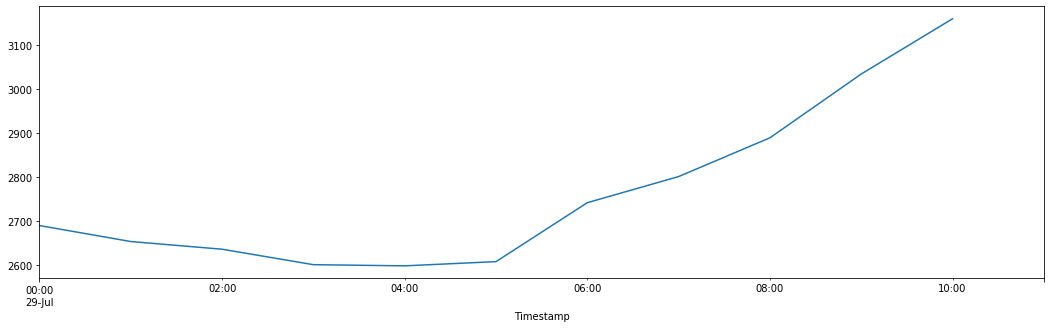

In [33]:
df[point_name].plot(figsize = (18,5))

In [34]:
y = df[point_name]
X = df.drop(columns=point_name)

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))

X_test = scaler.fit_transform(X)
y_test = scaler.fit_transform(np.array(y).reshape((-1,1)))


In [36]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:
prediction = model.predict(X_test)

In [38]:
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [39]:
index = df.index

<Figure size 1296x144 with 0 Axes>

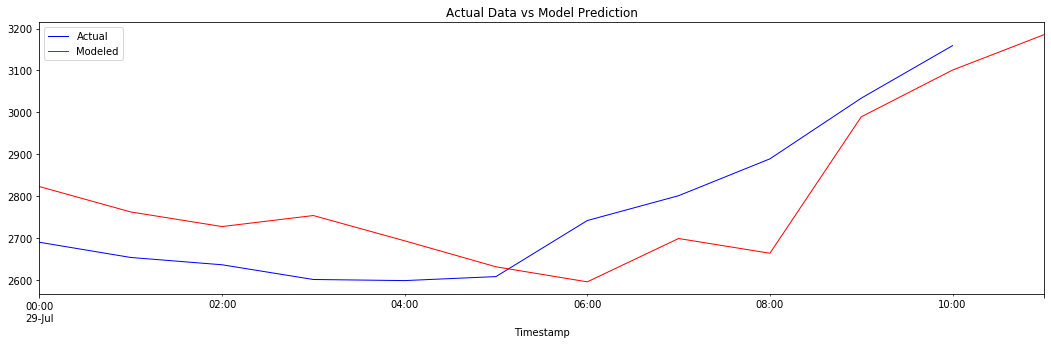

In [40]:
plt.figure(figsize=(18,2))
result = pd.DataFrame({"Actual":scaler.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":prediction.reshape((-1,))}, index=index)

result.plot(figsize=(18,5),
                         title="Actual Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])

In [41]:
result.tail()

,Actual,Modeled
Timestamp,,
2019-07-29 07:00:00,2801.391673,2699.318848
2019-07-29 08:00:00,2889.262685,2664.173584
2019-07-29 09:00:00,3033.907623,2989.415527
2019-07-29 10:00:00,3159.200582,3100.910156
2019-07-29 11:00:00,NaN,3185.170166


In [42]:
new_df.iloc[end].fillna(result['Modeled'].iloc[-1],inplace = True)
new_df['aiTIT4045'].index.searchsorted(new_df[point_name].isna().idxmax())

300

In [ ]:
#result.set_index(index, inplace = True)

In [ ]:
result.eval('Difference = (Actual - Modeled)/ Modeled * 100', inplace=True)

#result["Difference"] = result['Actual'] - result['Modeled']
result["Difference"] = result['Difference'].abs().round(decimals = 2)

In [ ]:
result.head()

In [ ]:
actual = result['Actual'].tolist()
modeled = result['Modeled'].tolist()
difference = result['Difference'].tolist()
idx = result.index.tolist()
ymax = max(max(actual, modeled))
ymin = min(min(actual, modeled))

In [ ]:
plt.figure(figsize=(18,10))
count = 1
for ii in range(len(actual)):
    
    if difference[ii] > anomaly_threshold:
        if count%2 == 0:
            plt.text(idx[ii] , ymin*0.99, int(difference[ii]), size = 11)
            count = count +1
        else:
            plt.text(idx[ii] , ymin*1.00, int(difference[ii]), size = 11)
            count = count +1
        plt.axvline(x = idx[ii], color = 'r', linestyle = '--')
plt.plot(idx, actual, marker = ".", color="#5bc0de", label = 'Actual')
plt.plot(idx, modeled, marker = ".", color="#E8743B", label = "Modeled")

plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(idx, actual, modeled, color = "grey", alpha = "0.3")
plt.yticks(actual, size= 10)
plt.xticks(idx, size = 10)

plt.locator_params(axis = 'y', tight = True, nbins=6)
plt.locator_params(axis = 'x', nbins = 6)
biggest_difference = result.loc[result['Difference'] == max(difference)]['Difference'][0]
at_time = result.loc[result['Difference'] == max(difference)].index[0]
plt.suptitle(f"{point_name}\n Actual vs Modeled", fontsize = 16)
plt.title(f"Threshold: {anomaly_threshold}%\n Biggest Difference:{int(biggest_difference)}% on {at_time}")
plt.legend()
plt.show()